In [31]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from lesson_functions import *

import concurrent
from moviepy.editor import VideoFileClip
from lesson_functions import *
import matplotlib.pyplot as plt
import matplotlib
from scipy.ndimage.measurements import label
import pickle
from collections import OrderedDict
from os.path import join

%matplotlib inline

In [32]:
def show_images(img1, title1, img2=None, title2=None):    
    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=30)    
    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=30)

In [33]:
image = mpimg.imread('./test_images/test1.jpg')

In [34]:
image.shape

(720, 1280, 3)

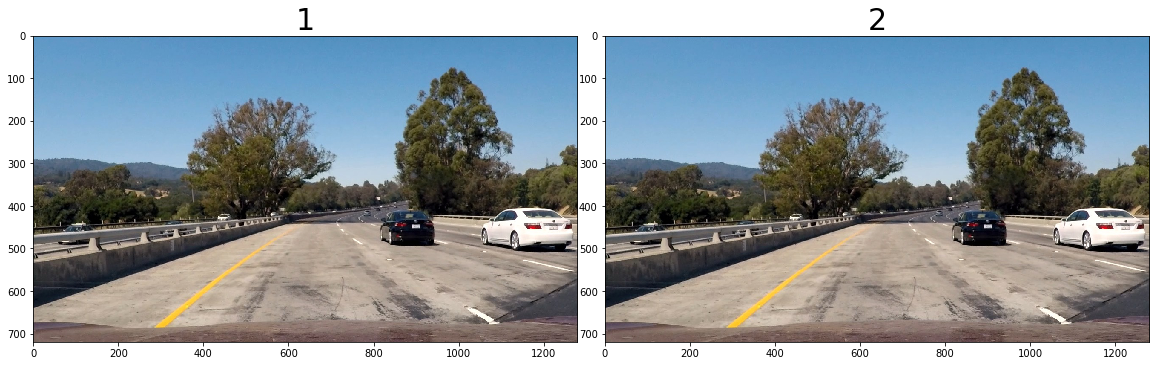

In [35]:
show_images(image, '1', image, '2')

In [36]:
file_name = "svc.p" #"0.0.6_svc.p"
with open(file_name, "rb") as ifile:
    svc, X_scaler = pickle.load(ifile)

In [37]:
color_space = 'HLS'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = "ALL"  # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)  # Spatial binning dimensions
hist_bins = 16  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off

In [38]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=(None, None), y_start_stop=(None, None), 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop_0 = 0
    if x_start_stop[1] == None:
        x_start_stop_1 = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop_0 = 0
    if y_start_stop[1] == None:
        y_start_stop_1 = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop_1 - x_start_stop_0
    yspan = y_start_stop_1 - y_start_stop_0
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop_0
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop_0
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=(None, None), y_start_stop=(None, None), 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))

In [39]:
# x_start_stop = (120, 1280-120)
# y_start_stop = (375, 500)

In [40]:
startx = 0
starty = 0
endx = 200
endy = 200
boxed_img = draw_boxes(image, [((startx, starty), (endx, endy))])

In [41]:
bi = draw_boxes(image, windows)

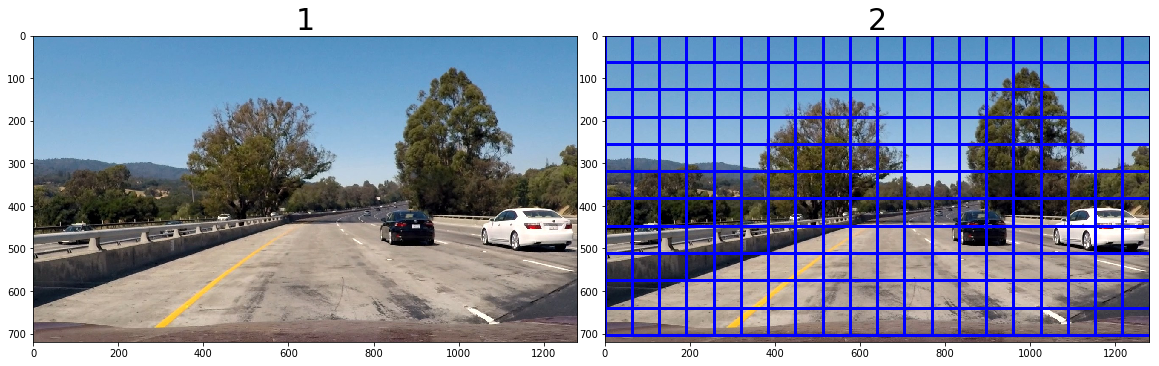

In [64]:
show_images(image, '1', bi, '2')

In [65]:
def run_windowing_and_detection_with_image(arg):
    xy_size, param_dict, image = arg[0], arg[1], arg[2]
    windows = slide_window_from_bottom(
        image, x_start_stop=param_dict["x_start_stop"], y_start_stop=param_dict["y_start_stop"],
        xy_window=(xy_size, xy_size), xy_overlap=param_dict["xy_overlap"])

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, spatial_feat=spatial_feat,
                                 hist_feat=hist_feat, hog_feat=hog_feat)
    return hot_windows

In [45]:
window_params = OrderedDict([
    (64, {"xy_overlap": (0.75, 0.75), "x_start_stop": (120, 1280-120), "y_start_stop": (375, 500)}),
    (70, {"xy_overlap": (0.75, 0.75), "x_start_stop": (60, 1280-60), "y_start_stop": (375, 500)}),
    (90, {"xy_overlap": (0.75, 0.75), "x_start_stop": (0, 1280), "y_start_stop": (375, 560)}),
    (115, {"xy_overlap": (0.5, 0.5), "x_start_stop": (0, 1280), "y_start_stop": (375, 600)}),
    (154, {"xy_overlap": (0.5, 0.5), "x_start_stop": (0, 1280), "y_start_stop": (400, 680)}),
    (185, {"xy_overlap": (0.5, 0.5), "x_start_stop": (0, 1280), "y_start_stop": (450, 680)}),
    (218, {"xy_overlap": (0.5, 0.5), "x_start_stop": (0, 1280), "y_start_stop": (450, 680)}),
])

In [51]:
# def get_boxes_for_image(image, win_params):
#     cnv = convert_to_float_if_required(image)

#     boxes = []
#     with concurrent.futures.ProcessPoolExecutor() as executor:
#         for new_boxes in executor.map(run_windowing_and_detection_with_image,
#             [(k, v, cnv) for k, v in win_params.items()]):
#                 boxes += new_boxes
#     return boxes

In [67]:
cnv = convert_to_float_if_required(image)

boxes = []
with concurrent.futures.ProcessPoolExecutor() as executor:
    for new_boxes in executor.map(run_windowing_and_detection_with_image,
        [(k, v, cnv) for k, v in window_params.items()]):
            boxes += new_boxes

In [68]:
len(boxes)

72

In [61]:
#bi2 = get_boxes_for_image(image, window_params)

In [69]:
bi2 = draw_boxes(image, boxes)

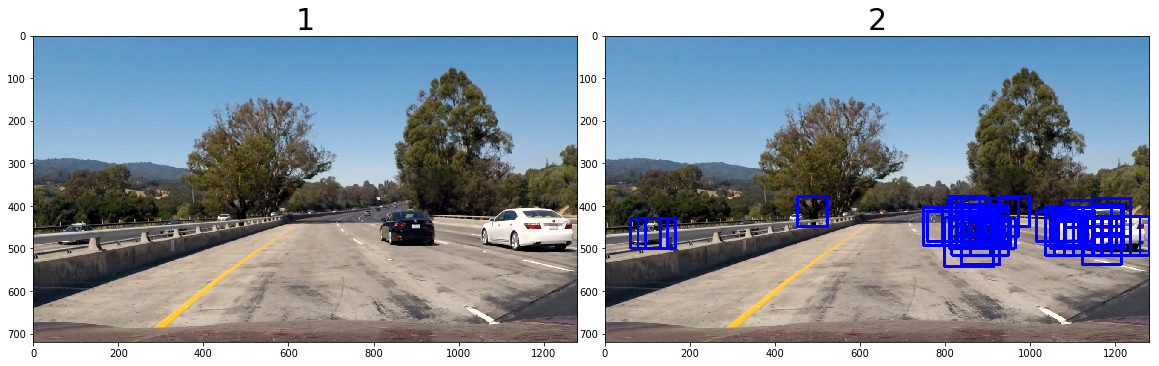

In [71]:
show_images(image, '1', bi2, '2')